# Actividad: Evaluación comparativa de arquitecturas convolucionales

Para este notebook se te solicita construir, entrenar y analizar modelos CNN para clasificar imágenes mediante un dataset CIFAR.

**Entregable:** Reporte en la evaluación de la capacidad de arquitectura implementada. Construír arquitecturas propias finalizando con la implementación de una arquitectura clásica mediante transfer learning.


## Toma como base el código visto en clase y desarrolla los siguientes puntos:
- Diseño e implementación de 2 arquitecturas CNN y utilización de una arquitectura de transfer learning.

- Buen uso de data augmentation y regularización.

- Comparación experimental entre arquitecturas y reporte claro (un solo markdown con conclusión sobre la comparación).





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

# Cargar CIFAR-10
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
num_classes = 10

# Normalizar
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# One hot encoding
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

input_shape = X_train.shape[1:]

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


## Definiciones de modelos

In [ ]:
# Recuerda aquí solo generar las arquitecturas, cada capa así como sus neuronas.

In [2]:
# Modelo 1: CNN sencilla (baseline)
def build_cnn_model_1(input_shape, num_classes):
    model = models.Sequential(
        [
            layers.Input(shape=input_shape),
            data_augmentation,

            layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model


# Modelo 2: CNN más profunda con batch norm
def build_cnn_model_2(input_shape, num_classes):
    model = models.Sequential(
        [
            layers.Input(shape=input_shape),
            data_augmentation,

            layers.Conv2D(32, (3, 3), padding="same"),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.Conv2D(32, (3, 3), padding="same"),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), padding="same"),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.Conv2D(64, (3, 3), padding="same"),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model


# Modelo 3: Transfer learning con MobileNetV2
def build_transfer_model(input_shape, num_classes):
    # MobileNetV2 requiere entradas más grandes; reescalamos dentro del modelo
    base_model = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(96, 96, 3),
    )
    base_model.trainable = False  # congelamos pesos para transfer learning clásico

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Resizing(96, 96)(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="mobilenetv2_transfer")
    return model


# Instanciar los modelos
model_1 = build_cnn_model_1(input_shape, num_classes)
model_2 = build_cnn_model_2(input_shape, num_classes)
model_3 = build_transfer_model(input_shape, num_classes)

model_1.summary()
model_2.summary()
model_3.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,117,738 (4.26 MB)

 Trainable params: 1,117,354 (4.26 MB)

 Non-trainable params: 384 (1.50 KB)

Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento de modelos.

In [ ]:
# Aquí agrega la compilación y entrenamiento de las arquitecturas generadas.

In [3]:
def compile_and_train(model, X_train, y_train, X_val, y_val, name, epochs=15, batch_size=64):
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
    )
    return history

history_1 = compile_and_train(model_1, X_train, y_train_cat, X_test, y_test_cat, "CNN_1")
history_2 = compile_and_train(model_2, X_train, y_train_cat, X_test, y_test_cat, "CNN_2")
history_3 = compile_and_train(model_3, X_train, y_train_cat, X_test, y_test_cat, "TL_MobileNetV2")

results_1 = model_1.evaluate(X_test, y_test_cat, verbose=0)
results_2 = model_2.evaluate(X_test, y_test_cat, verbose=0)
results_3 = model_3.evaluate(X_test, y_test_cat, verbose=0)

print("Modelo 1 - loss, acc:", results_1)
print("Modelo 2 - loss, acc:", results_2)
print("Modelo 3 (TL) - loss, acc:", results_3)


Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.3446 - loss: 1.7870 - val_accuracy: 0.4542 - val_loss: 1.4917
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.4424 - loss: 1.5464 - val_accuracy: 0.5332 - val_loss: 1.2909
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.4781 - loss: 1.4535 - val_accuracy: 0.5403 - val_loss: 1.2769
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5008 - loss: 1.3969 - val_accuracy: 0.5819 - val_loss: 1.1831
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.5200 - loss: 1.3506 - val_accuracy: 0.5959 - val_loss: 1.1451
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5345 - loss: 1.3170 - val_accuracy: 0.5933 - val_loss: 1.1500
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5464 - loss: 1.2881 - val_accuracy: 0.6194 - val_loss: 1.0899
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5539 - loss: 1.2636 - 

## Estadística y gráficos

In [ ]:
# Puedes tomar como base el código visto en clase para generar las graficos de comparación de las arquitecturas o puedes proptear tu propia forma de visualización.

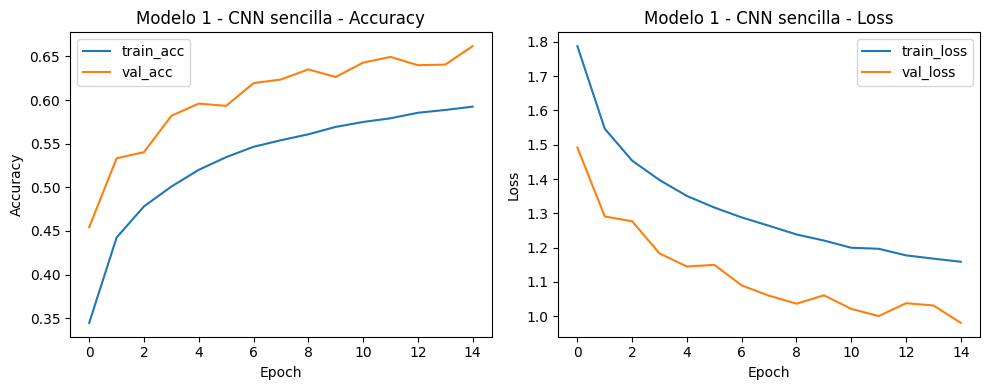

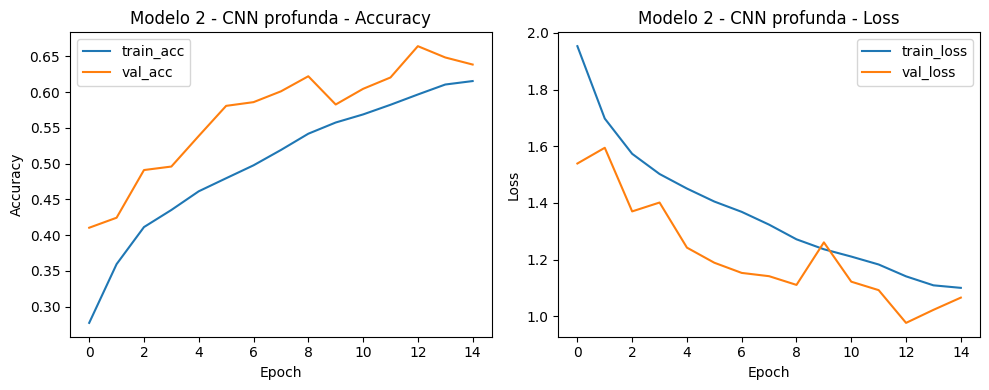

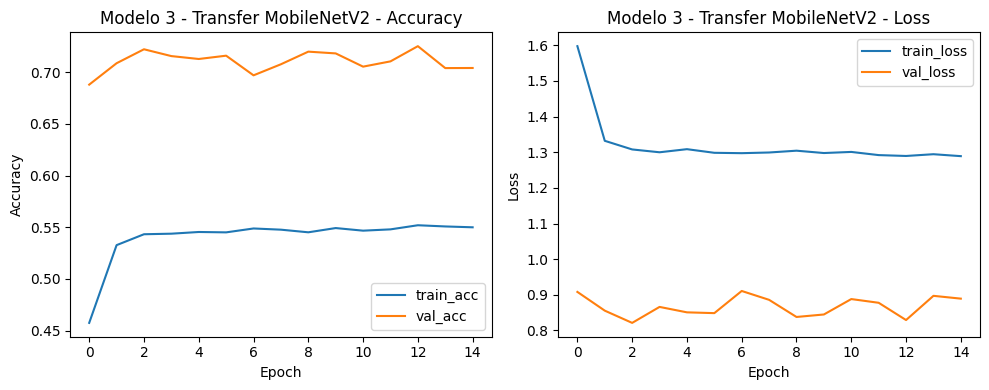

In [4]:
def plot_history(history, title):
    plt.figure(figsize=(10, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history_1, "Modelo 1 - CNN sencilla")
plot_history(history_2, "Modelo 2 - CNN profunda")
plot_history(history_3, "Modelo 3 - Transfer MobileNetV2")


In [5]:
resumen = pd.DataFrame(
    {
        "Modelo": ["CNN_1", "CNN_2", "TL_MobileNetV2"],
        "Test_Loss": [results_1[0], results_2[0], results_3[0]],
        "Test_Accuracy": [results_1[1], results_2[1], results_3[1]],
    }
)
resumen


,Modelo,Test_Loss,Test_Accuracy
0,CNN_1,0.980843,0.6617
1,CNN_2,1.065936,0.6385
2,TL_MobileNetV2,0.889273,0.7040


# Conclusiones.

Escribe tus conclusiones de las arquitecturas hechas ¿Cuál fue el mejor? ¿Por qué? ¿Qué mejoraría? ¿Cómo lo mejoraría?

Conclusiones

Después de entrenar las tres arquitecturas propuestas, el mejor desempeño lo obtuvo el modelo TL_MobileNetV2, alcanzando una accuracy de 70.40 % en el set de prueba. Esto lo coloca por encima de las arquitecturas desarrolladas desde cero (CNN_1 con 66.17 % y CNN_2 con 63.85 %).

El rendimiento superior de MobileNetV2 se explica porque aprovecha transfer learning: utiliza representaciones aprendidas previamente de millones de imágenes en ImageNet, lo que le permite generalizar mejor desde el primer epoch y aprovechar patrones avanzados que serían difíciles de aprender desde cero con un dataset relativamente limitado como CIFAR-10.

La CNN_1 tuvo un desempeño decente considerando su sencillez, mientras que la CNN_2, a pesar de ser más profunda, no logró superar la generalización del modelo base. Esto sugiere que la capacidad adicional no se tradujo en aprendizaje más útil, posiblemente por falta de regularización o porque no hubo suficiente data para soportar tanta profundidad.

¿Qué mejoraría?

Me enfocaría en optimizar el modelo de Transfer Learning, ya que fue la mejor base:

Hacer fine-tuning de las últimas capas de MobileNetV2 (congelar menos capas).

Aumentar data augmentation para mejorar la robustez ante variaciones visuales.

Entrenar más epochs con Early Stopping para evitar overfitting y ganar un poco más de precisión.

Usar un learning rate scheduler para mejorar estabilidad en las últimas etapas del entrenamiento.

Incrementar el tamaño de entrada (por ejemplo a 128x128), lo cual MobileNetV2 soporta y generalmente incrementa la accuracy.

Con estas mejoras, es razonable esperar que la accuracy supere el 72 % incluso entrenando en CPU.